# Amazon Reviews - Sentiment Model Experimentation

### Imports

In [10]:
# !conda install -y -c conda-forge fastparquet scikit-learn arrow-cpp parquet-cpp pyarrow numpy
# !pip install --upgrade mxnet gluonnlp
!pip install fast-bert


    100% |████████████████████████████████| 81kB 42.0MB/s ta 0:00:01
    100% |████████████████████████████████| 3.8MB 12.1MB/s eta 0:00:01
    100% |████████████████████████████████| 204kB 64.8MB/s eta 0:00:01
    100% |████████████████████████████████| 10.6MB 4.6MB/s  eta 0:00:01
    100% |████████████████████████████████| 573kB 56.3MB/s eta 0:00:01
    100% |████████████████████████████████| 1.3MB 31.1MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 47.2MB/s ta 0:00:01
    100% |████████████████████████████████| 194kB 65.7MB/s eta 0:00:01
    100% |████████████████████████████████| 3.7MB 13.5MB/s ta 0:00:011
    100% |████████████████████████████████| 122kB 61.5MB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 29.6MB/s eta 0:00:01
    100% |████████████████████████████████| 686kB 49.4MB/s eta 0:00:01
    100% |████████████████████████████████| 870kB 47.5MB/s eta 0:00:01
    100% |████████████████████████████████| 1.0MB 35.4MB/s ta 0:00:011
    54% |█

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    64% |████████████████████▊           | 488.7MB 97.0MB/s eta 0:00:03

    65% |█████████████████████           | 493.7MB 98.8MB/s eta 0:00:03

    66% |█████████████████████▏          | 498.7MB 97.6MB/s eta 0:00:03

    66% |█████████████████████▍          | 503.7MB 98.4MB/s eta 0:00:03

    67% |█████████████████████▋          | 508.6MB 99.0MB/s eta 0:00:03

    68% |█████████████████████▉          | 513.6MB 98.4MB/s eta 0:00:03

    68% |██████████████████████          | 518.6MB 100.1MB/s eta 0:00:03

    70% |██████████████████████▌         | 528.5MB 95.2MB/s eta 0:00:03

    70% |██████████████████████▋         | 533.5MB 100.0MB/s eta 0:00:03

    71% |██████████████████████▉         | 538.4MB 95.6MB/s eta 0:00:03

    72% |███████████████████████         | 543.4MB 94.3MB/s eta 0:00:03

    72% |███████████████████████▎        | 548.3MB 98.0MB/s eta 0:00:03

    73% |███████████████████████▌        | 553.3MB 97.7MB/s eta 0:00:03

    74% |███████████████████████▊        | 558.3MB 98.6MB/s eta 0:00:02

    74% |████████████████████████        | 563.2MB 94.2MB/s eta 0:00:03

    75% |████████████████████████▏       | 568.2MB 98.3MB/s eta 0:00:02

    76% |████████████████████████▍       | 573.2MB 97.3MB/s eta 0:00:02

    76% |████████████████████████▌       | 578.1MB 95.5MB/s eta 0:00:02

    77% |████████████████████████▊       | 583.0MB 95.2MB/s eta 0:00:02

    77% |█████████████████████████       | 587.5MB 74.2MB/s eta 0:00:03

    78% |█████████████████████████▏      | 592.2MB 73.3MB/s eta 0:00:03

    79% |█████████████████████████▍      | 597.3MB 102.4MB/s eta 0:00:02

    79% |█████████████████████████▋      | 602.2MB 95.8MB/s eta 0:00:02

    80% |█████████████████████████▉      | 607.2MB 94.0MB/s eta 0:00:02

    81% |██████████████████████████      | 612.1MB 94.1MB/s eta 0:00:02

    81% |██████████████████████████▏     | 617.1MB 97.1MB/s eta 0:00:02

    82% |██████████████████████████▍     | 622.1MB 98.8MB/s eta 0:00:02

    83% |██████████████████████████▋     | 627.0MB 98.9MB/s eta 0:00:02

    83% |██████████████████████████▉     | 632.0MB 94.5MB/s eta 0:00:02

    84% |███████████████████████████     | 636.9MB 94.7MB/s eta 0:00:02

    85% |███████████████████████████▎    | 641.9MB 96.2MB/s eta 0:00:02

    85% |███████████████████████████▌    | 646.8MB 95.9MB/s eta 0:00:02

    86% |███████████████████████████▋    | 651.3MB 99.9MB/s eta 0:00:02

    87% |███████████████████████████▉    | 656.0MB 74.2MB/s eta 0:00:02

    87% |████████████████████████████    | 660.7MB 75.7MB/s eta 0:00:02

    88% |████████████████████████████▎   | 665.3MB 69.8MB/s eta 0:00:02

    88% |████████████████████████████▌   | 670.1MB 100.7MB/s eta 0:00:01

    89% |████████████████████████████▊   | 675.0MB 100.2MB/s eta 0:00:01

    90% |████████████████████████████▉   | 679.7MB 100.8MB/s eta 0:00:01

    90% |█████████████████████████████   | 684.4MB 98.0MB/s eta 0:00:01

    91% |█████████████████████████████▎  | 689.3MB 102.7MB/s eta 0:00:01

    92% |█████████████████████████████▌  | 694.3MB 97.2MB/s eta 0:00:01

    92% |█████████████████████████████▊  | 699.3MB 97.1MB/s eta 0:00:01

    93% |██████████████████████████████  | 704.3MB 97.1MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    100% |████████████████████████████████| 753.4MB 69kB/s 
    100% |████████████████████████████████| 4.0MB 19.7MB/s eta 0:00:01
    100% |████████████████████████████████| 112kB 58.8MB/s ta 0:00:01
    100% |████████████████████████████████| 552kB 48.5MB/s ta 0:00:011
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
  Running setup.py bdist_wheel for sacremoses ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sklearn sacremoses
transformers 2.8.0 has requirement tokenizers==0.5.2, but you'll have tokenizers 0.6.0 which is incompatible.
  Found existing installation: protobuf 3.5.2
    Uninstalling protobuf-3.5.2:
      Successfully uninstalled protobuf-3.5.2
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip in

In [1]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
import nltk
from fastparquet import write
from fastparquet import ParquetFile
import s3fs
import pyarrow.parquet as pq
import pickle
import glob
import ast 
import csv

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics


### Configs and Global Vars

In [2]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'demos-amazon-reviews',
    'prefix' : 'preprocessed_reviews_csvs', #only use this if you want to have your files in a folder 
    'index_key' : 'review_date_str',
    'file_extension' :'.csv',
    'wordvecdata': 'wordvec-data'
}

global_vars = {}

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [3]:
def setup_env(configs, global_vars):
    
    sess = sagemaker.Session()
    
    role = get_execution_role()

    AWS_REGION = configs['aws_region']
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(configs['bucket_name'])

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
        
    global_vars['role'] = role
    global_vars['sess'] = sess
    global_vars['s3'] = s3
    global_vars['s3_bucket'] = s3_bucket
    
    return global_vars

global_vars = setup_env(configs, global_vars)

Bucket already exists


### Create Data Manifest

At this step, we need to create an index of all the files we're going to be using for this experiment and model building. Now, we don't want to download all of the data at once, or we're going to cause a lot of I/O activity for your Notebook Instance. 

What we're going to do is first create a path index to where the files live on S3. From there, we can do some sampling to get to see what the data looks like, do some basic sampling stats on the data, to get a better handle on how we should build a model, and then move to using all the data to build a robust model!

In [ ]:
def create_dataset_manifest(configs, global_vars):
    
    interval_printer_idx = 100
    idx = 0
    1
    conn = global_vars['s3_bucket']
    file_format = configs['file_extension']
    index_key = configs['index_key']+'='
    s3_prefix = configs['prefix']+'/'
    manifest = []    
    for file in conn.objects.filter(Prefix=s3_prefix):
        path = file.key
#         print(file)
        if (file_format in path):
#             print(path)
            relative_path = path.replace(configs['prefix'],'')
            date = relative_path.split('/')[1].replace(index_key,'')

            man = {'idx':idx, 'path':relative_path, 'path_with_prefix':path, 'date':date}
            manifest.append(man)  
            idx += 1
            if (idx % interval_printer_idx) == 0:
                print('Processed {} files'.format(idx))
    print('Training Dataset Size {}'.format(len(manifest)))
    return manifest
            
manifest = create_dataset_manifest(configs, global_vars)   
    

In [ ]:
def count_lines(configs, global_vars, entry):
        
    s3 = boto3.client('s3')

    resp = s3.select_object_content(
        Bucket=configs['bucket_name'],
        Key=entry['path_with_prefix'],
        ExpressionType='SQL',
        Expression="SELECT count(*) FROM s3object s",
        InputSerialization = {'CSV':
                              {"FileHeaderInfo": "Use", 
                               "AllowQuotedRecordDelimiter": True,
                               "QuoteEscapeCharacter":"\\",
                              }, 
                              'CompressionType': 'NONE'},
        OutputSerialization = {'CSV':{}},
    )
    
    for event in resp['Payload']:
        if 'Records' in event:
            records = event['Records']['Payload'].decode('utf-8')
#             print('Rows:',records)
            return(int(records))
    
count_lines(configs, global_vars, manifest[240])

### Explore Manifest Stats

Given that we know what the index of our manifest is partitioned by, let's do some simple stats to learn more about our manifest so we can make some informed decisions for our sampling and modelling

In [ ]:
def generate_manifest_statistics(configs, global_vars, manifest):
    
    date_cnt = {}
    stats = {}

    for entry in manifest:
        
        date = entry['date']
        cnt = count_lines(configs, global_vars, entry)
        date_cnt[date] = cnt
        print(date,cnt)

    tmp = []
    for date, cnt in date_cnt.items():
        itm = {'date':date, 'files':cnt}
        tmp.append(itm)
    df_stats = pd.DataFrame(tmp)
    df_stats.plot.bar(x='date', y='files', figsize=(40,10))  
    df_stats.plot.kde()
    print('Total folders {}'.format(df_stats.shape[0]))
    print('Total Files {}'.format(df_stats.sum()['files']))
    print('Date with most files {}. Files: {}'.format(df_stats.max()['date'], df_stats.max()['files']))
    print('Date with least files {}. Files: {}'.format(df_stats.min()['date'], df_stats.min()['files']))
    print('File Kurtosis/Skew {}/{}'.format(df_stats.kurtosis()['files'], df_stats.skew()['files']))

    notes = '''
        once we examine the distribution, we can determine how we are going to sample our manifest to get a better 
        understanding of our reviews. Remember the plot only represents the number of files in each folder. but
        there is a linear relationship between the number of files, and the number of reviews per bin'''
    
    print(notes)
    
    return df_stats
    
manifest_df_stats = generate_manifest_statistics(configs,global_vars, manifest)

### Generate Sample Dataset

Now we're going to generate a sample of our dataset to ensure that we get some views of how the data looks and feels across the years.

In [ ]:
def generate_sample_dataset(configs, manifest, manifest_df_stats, sample_size_pct = 0.01, strategy = 'binned_normal'):
    
    dfs_sampled = []
    index_key = configs['index_key']+'='

    notes = '''
        Based on the manifest inspection, we can now use a suitable sampling strategy in order to generate a smaller 
        manifest to work on locally.'''
    
    strategies = ['statified', 'random', 'clustered', 'systematic', 'binned_normal']
    if strategy in strategies:
        print('Using {} Strategy'.format(strategy))
    else:
        print('Please use one of these strategies {}'.format(strategies))
    
    if strategy is 'binned_normal':
        sample_meta = {}
        #we take a pct of each of the rows, and then use random to select within each bin
        #workout the overall pct we need to take
#         sample_pct = float(manifest_df_stats.shape[0] * sample_size)
        for idx,row in manifest_df_stats.iterrows():
            to_sample = int(row['files'] * sample_size_pct)
            if to_sample < 1:
                to_sample = 1
            date = row['date']    
            tmp = {'rows':row['files'], 'samples': to_sample, 'sampled_added':0}
            sample_meta[date] = tmp
            
#         print(sample_meta)
        #now we generate a new manifest
        
        sampled_manifest = []
        for entry in manifest:

            date = entry['path'].split('/')[1].replace(index_key,'')
            #get the meta data 
            meta = sample_meta[date]
            to_skip = meta['samples']
            if to_skip == 1:
                to_skip = 1
            full_path = 's3://'+configs['bucket_name']+'/'+entry['path_with_prefix']
            df = pd.read_csv(full_path, nrows=int(to_skip), header=0, error_bad_lines=False, escapechar="\\")
            print(date, df.shape)
            dfs_sampled.append(df)
        
    elif strategy in strategies:
        print('Other Stratigies will be supported Soon!')
    
    sampled_data = pd.concat(dfs_sampled)

    print('New Dataset Length {}'.format(sampled_data.shape[0]))
    
    return sampled_data
    
sampled_data = generate_sample_dataset(configs, manifest, manifest_df_stats)

In [4]:
def save_load_sample_df_to_file(df, path = 'data', file_name_prefix='', operation='save', chunkSize = 100000):
    
    
    loaded = []
    #first split the df as it's too big probably
    listOfDf = list()
    if operation == 'save':

        numberChunks = len(df) // chunkSize + 1
        for i in range(numberChunks):
            listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
            
        for i in range(0, len(listOfDf)):
            chunk_df = listOfDf[i]
            df_tmp_name_prefix = '{}/{}_part_{}.pkl'.format(path, file_name_prefix, str(i))
            chunk_df.to_pickle(df_tmp_name_prefix) 
                       
        return df
                       
    if operation == 'load':
        root_name = '{}/{}_*.pkl'.format(path, file_name_prefix)
        files = glob.glob(root_name)
        for fl in files:       
            print(fl)
            df = pd.read_pickle(fl)
            loaded.append(df)
                       
        return pd.concat(loaded)
    
sampled_data = save_load_sample_df_to_file(None, path='data', file_name_prefix = 'sample_df', operation='load')   

data/sample_df_part_7.pkl
data/sample_df_part_5.pkl
data/sample_df_part_14.pkl
data/sample_df_part_6.pkl
data/sample_df_part_12.pkl
data/sample_df_part_4.pkl
data/sample_df_part_8.pkl
data/sample_df_part_1.pkl
data/sample_df_part_2.pkl
data/sample_df_part_9.pkl
data/sample_df_part_0.pkl
data/sample_df_part_3.pkl
data/sample_df_part_10.pkl
data/sample_df_part_11.pkl
data/sample_df_part_13.pkl


In [5]:
def ready_sample_data(df):
    
    print('Dataset Rows {}, Columns {}'.format(df.shape[0], df.shape[1]))
    df['review_date']= pd.to_datetime(df['review_date']) 
    #convert date to string with format yyyy-mm
    df['review_date_str'] = df['review_date'].dt.strftime('%Y-%m')
    
    #here we need to do some basic filtering of rows, we don't want to start to model for 
    df_len = df.shape[0]
    pct_min = 0.01
    min_product_category_row_count = df_len * pct_min #should be around 1% of the dataset, Imbalanced data will skew our modelling
    
    df = df.groupby('product_category').filter(lambda x : len(x)>min_product_category_row_count)

    print('After Processing Data: Dataset Rows {}, Columns {}'.format(df.shape[0], df.shape[1]))

    return df

sampled_data = ready_sample_data(sampled_data)

Dataset Rows 1487293, Columns 18
After Processing Data: Dataset Rows 1437684, Columns 19


In [ ]:
def analyse_sample_dataset(df):
   

    print(df.columns)
    print(df.shape)
    print(df.describe())

#     print(df.groupby(['review_date_str','product_category']).count())
    tmps = []
    for name,group in df.groupby(['review_date_str','product_category']):
        unique_products = len(group['product_id'].unique().tolist())
        products_with_multiple_reviews = group.shape[0]- unique_products
        tmp = {'review_date': name[0],
               'product_category': name[1], 
               'entries':group.shape[0], 
               'unique_products':unique_products,
              'products_with_multiple_reviews':products_with_multiple_reviews }
#         print(name, group.shape[0], unique_products)

        tmps.append(tmp)
    
    df_counts_cat_years = pd.DataFrame(tmps)
    df_counts_cat_years['review_date']= pd.to_datetime(df_counts_cat_years['review_date']) 
    df_counts_cat_years.groupby('product_category')['entries'].plot(legend=True, figsize=(30,20)) 
    plt.show()    
    
    df_counts_cat_years.groupby([df_counts_cat_years['review_date'].dt.year, df_counts_cat_years['review_date'].dt.month]).sum()['unique_products'].plot(kind='bar', legend=True, figsize=(30,20)) 
    plt.show()
   
    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year).sum()['products_with_multiple_reviews'].plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()

    df_counts_cat_years.groupby(df_counts_cat_years['review_date'].dt.year)['entries'].sum().plot(kind='bar',legend=True, figsize=(30,20))
    plt.show()
    
analyse_sample_dataset(sampled_data)

## Model /Analysis Experimentation (Local Mode)

The purpose of this section is to perform some experimentations with different modelling techniques.

We're first going to perform some local experiments on the 1% sample of data to see which methods provide valuable insights for both customers (e.g. Amazon Customer), and operations (e.g. Amazon). 

We want to look at different type of insights, from understanding how customer reviews have changed over times, and whether there is predictability in the type of review, and the category of product it is related to. 

Let's start of by first gettign our data into a shape which we can use for analysis and modelling purposes

### Prep Data for Modelling Purposes

We're going to develop some dataframes which represent our Xs and Ys (features and labels).

Let's create some feature/label datasets which are shaped around the following labels:

- year_product-category
- product-category_star_rating

The features for this model will be only using the text of the reviews





In [8]:
def transform_data_for_modelling_use(df):
    
    #first let's get all our data in correct buckets of features and labels
    tmps = list()
    
    #first let's do the year_product-category grouping
    for name,group in df.groupby([df['review_date'].dt.year,'product_category']):
        label = '{}_{}'.format(name[0],name[1])
#         print(label)
        tokens = list()
        reviews = group['review_body_processed']
        for review in reviews:
#             print (type(review)) 
            res = str(review).strip('][').split(', ') 
            tokens.append(res)
#         print(len(tokens))
        tmp = {'tokens':tokens, 'label':label }
#         print(tmp)
        tmps.append(tmp)
    
    df_year_product_category = pd.DataFrame(tmps)

    tmps = list()
    #let's do the product-category-rating grouping
    for name,group in df.groupby(['product_category','star_rating']):
        label = '{}_stars_{}'.format(name[0],name[1])
        print(label)
        tokens = list()
        reviews = group['review_body_processed']
        for review in reviews:
            res = str(review).strip('][').split(', ') 
            tokens.append(res)
        tmp = {'tokens':tokens, 'label':label }
        tmps.append(tmp)
    
    df_product_category_rating = pd.DataFrame(tmps)

    
    return df_year_product_category, df_product_category_rating

df_year_product_category, df_product_category_rating = transform_data_for_modelling_use(sampled_data)        

Apparel_stars_1
Apparel_stars_2
Apparel_stars_3
Apparel_stars_4
Apparel_stars_5
Automotive_stars_1
Automotive_stars_2
Automotive_stars_3
Automotive_stars_4
Automotive_stars_5
Baby_stars_1
Baby_stars_2
Baby_stars_3
Baby_stars_4
Baby_stars_5
Beauty_stars_1
Beauty_stars_2
Beauty_stars_3
Beauty_stars_4
Beauty_stars_5
Books_stars_1
Books_stars_2
Books_stars_3
Books_stars_4
Books_stars_5
Camera_stars_1
Camera_stars_2
Camera_stars_3
Camera_stars_4
Camera_stars_5
Digital_Ebook_Purchase_stars_1
Digital_Ebook_Purchase_stars_2
Digital_Ebook_Purchase_stars_3
Digital_Ebook_Purchase_stars_4
Digital_Ebook_Purchase_stars_5
Digital_Music_Purchase_stars_1
Digital_Music_Purchase_stars_2
Digital_Music_Purchase_stars_3
Digital_Music_Purchase_stars_4
Digital_Music_Purchase_stars_5
Digital_Video_Download_stars_1
Digital_Video_Download_stars_2
Digital_Video_Download_stars_3
Digital_Video_Download_stars_4
Digital_Video_Download_stars_5
Electronics_stars_1
Electronics_stars_2
Electronics_stars_3
Electronics_sta

### Save the features for use later

As these dataframes can take a while to generate, it's useful to save them if the notebook is shutdown, or the kernal dies. These things happen:)

In [33]:
save_load_sample_df_to_file(df_year_product_category, 
                            path='data', 
                            file_name_prefix = 'features_df_year_product_category', 
                            operation='save', chunkSize=10)   

save_load_sample_df_to_file(df_product_category_rating, 
                            path='data', 
                            file_name_prefix = 'features_df_product_category_star', 
                            operation='save', chunkSize=10)   

,label,tokens
0,1995_Books,"[[nice, diags, lucid, explanations, rigging, g..."
1,1996_Books,"[[nine, doors, midgard, excellent, sourcebook,..."
2,1997_Books,"[[im, avid, cook, voracious, reader, cook, boo..."
3,1997_Music,"[[summers, 1992, selftitled, record, followed,..."
4,1997_Video_DVD,"[[bye, bye, birdie, delicious, slice, musical,..."
5,1998_Books,"[[graduate, unc, rabid, fan, tar, heels, heard..."
6,1998_Music,"[[cds, one, great, songs, especially, like, si..."
7,1998_Video_DVD,"[[marisa, tormei, plays, woman, told, fortune,..."
8,1999_Automotive,"[[recently, installed, system, 2000, mitsubush..."
9,1999_Books,"[[loved, book, realy, liked, fact, andalites, ..."


## TF-IDF - Temporal Analysis of Product Categories


In [9]:
#util code

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [10]:
def generate_label_category(row, grouping_type):
    
    if grouping_type == 'year':
        label = row['label']
        category = "_".join(label.split('_')[1:])
        sub_cat = label.split('_')[0]
        
        
    if grouping_type == 'star':
        label = row['label']
        category = label.split('stars')[0]
        sub_cat = label.split('stars')[1]
        
    return category, sub_cat
        
        
    

def prepare_data_for_tfidf(df, grouping_type):
     
    data_grouped = dict()
    for idx,row in df.iterrows():
#         label = row['label']
#         category = "_".join(label.split('_')[1:])
#         year = label.split('_')[0]
        category, sub_cat = generate_label_category(row, grouping_type)
        if category in data_grouped:
            docs = data_grouped[category]
        else:
            docs = list()

        tokens = row['tokens']
        docs_tmp = [" ".join(x) for x in tokens]
        docs = docs + docs_tmp
        data_grouped[category] = docs
    
    tfidf_handlers = dict()
    for k,v in data_grouped.items():
        print(k, len(v))
        cv = CountVectorizer(max_features=10000)
        word_count_vector=cv.fit_transform(v)
        feature_names=cv.get_feature_names()
        tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
        tfidf_transformer.fit(word_count_vector)
        tfidf_handlers[k] = {'cv': cv, 'feature_names': feature_names, 'tfidf_transformer':tfidf_transformer}

    tfidf_scores = {} #keep track of tf-idf scores for category by year
    for idx,row in df.iterrows():
        
        category, sub_cat = generate_label_category(row, grouping_type)

        if category in tfidf_scores:
            sub_scores = tfidf_scores[category]
        else:
            sub_scores = dict()

        tfidf_transformer=tfidf_handlers[category]['tfidf_transformer']
        feature_names=tfidf_handlers[category]['feature_names']
        cv=tfidf_handlers[category]['cv']
        tokens = row['tokens']
        doc = [" ".join(x) for x in tokens]

        tf_idf_vector=tfidf_transformer.transform(cv.transform(doc))
        sorted_items=sort_coo(tf_idf_vector.tocoo())
        keywords=extract_topn_from_vector(feature_names,sorted_items,100)
        
        sub_scores[sub_cat] = keywords
        tfidf_scores[category] = sub_scores

    return tfidf_scores

tfidf_scores = prepare_data_for_tfidf(df_year_product_category, grouping_type='year')

Books 193606
Music 46377
Video_DVD 49250
Automotive 35293
Camera 17565
Electronics 31860
Home_Improvement 26095
Office_Products 25115
PC 68088
Tools 17763
Toys 50558
Video_Games 17170
Wireless 89363
Baby 16649
Home 61812
Kitchen 46492
Lawn_and_Garden 25412
Outdoors 22518
Sports 47688
Beauty 50556
Grocery 23750
Health_&_Personal_Care 52120
Apparel 61003
Jewelry 17951
Pet_Products 25120
Shoes 43825
Digital_Ebook_Purchase 171063
Digital_Video_Download 39863
Digital_Music_Purchase 15862
Mobile_Apps 47897


### Temporal Overlap in TF-IDF Terms

In [11]:
def calc_temporal_overlap_tfidf(dic_of_scores):
    
    tfidf_overlaps = []
    for k,v in dic_of_scores.items():
            ordered = OrderedDict(v)
            keys = list(ordered.keys())
            for i in range(0, len(keys)):
                if i < len(keys)-1:
                    year_n = keys[i]
                    year_n1 = keys[i+1]
                    bag = '{}_{}'.format(year_n,year_n1)
                    total_terms = set(ordered[year_n].keys()).union(set(ordered[year_n1].keys()))
                    overlap = set(ordered[year_n].keys()).intersection(set(ordered[year_n1].keys()))
                    pct_overlap = len(overlap) / len(total_terms)*100
                    tmp = {'category':k, 'year_from_to':year_n1, 'overlap_pct':pct_overlap}
                    tfidf_overlaps.append(tmp)
                
    df = pd.DataFrame(tfidf_overlaps)
    df['year_from_to']= pd.to_datetime(df['year_from_to']) 

    return df
                    
            
df_overlaps_tfidf = calc_temporal_overlap_tfidf(tfidf_scores)

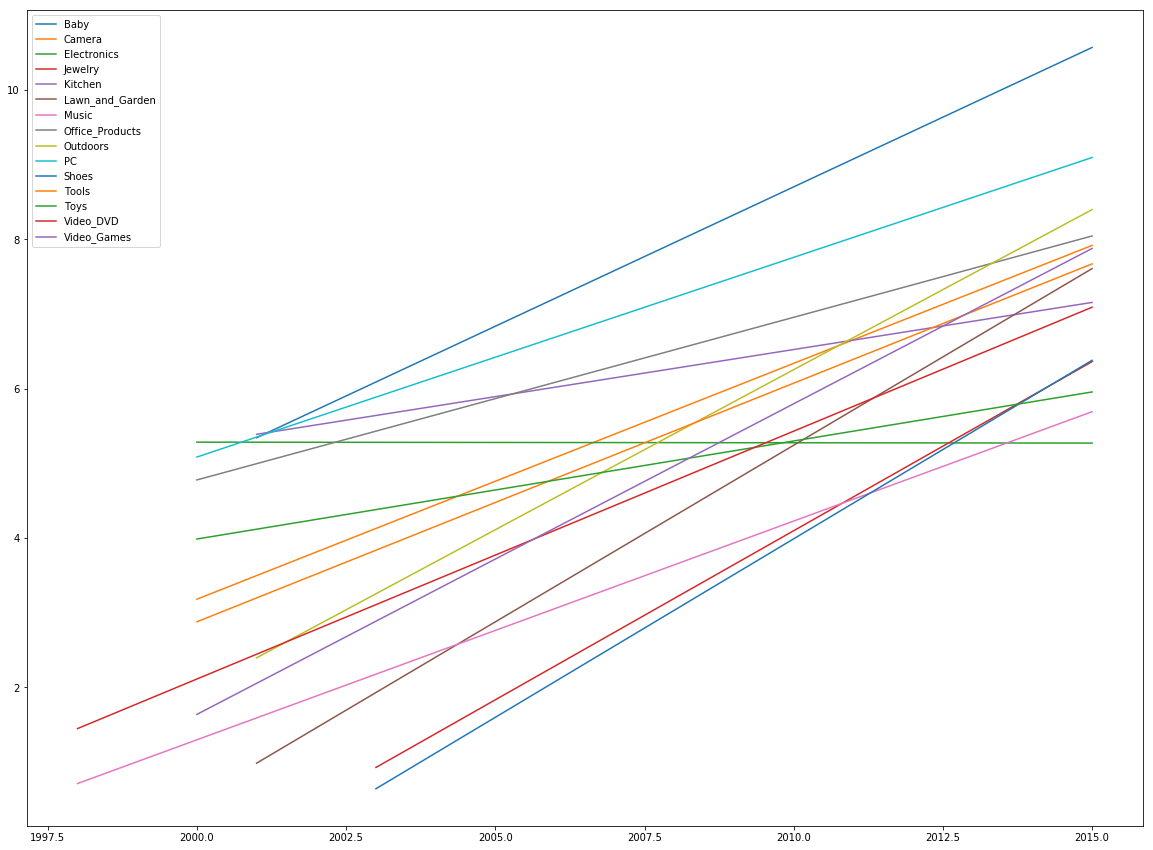

In [12]:
def plot_temporal_overlap(df):

    plt.figure(figsize=(20,15)) 

    for name, group in df.groupby('category'):
        x = group['year_from_to'].dt.year
        y = group['overlap_pct']
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        if z[0] < 0.5:
    #     plt.plot(x,y, label=name)
            plt.plot(x,p(x), label=name)

    plt.legend()
    plt.show()

plot_temporal_overlap(df_overlaps_tfidf)

**Notes**: At this point we can reflect on the results of the TF-IDF analysis to determine whether the terms which are being identified are useful, and also whether the transfer of terms across the years provides any value with respects to the overall consistency of language used within the reviews. One way of thinking about the results is that the language overlap could be considered as a metric of homogenity within the review samples. The current approach does not normalize against new products being introduced throughout the years, so it may be that this analysis is contaminated due to this factor.

### Perform Same exploration with Product Cateogry - Star Rating Analysis

In [22]:
def calc_star_rating_overlap_tfidf(dic_of_scores):
    
    tfidf_overlaps = []
    for k,v in dic_of_scores.items():
            ordered = OrderedDict(v)
            keys = list(ordered.keys())
            for i in range(0, len(keys)):
                if i < len(keys)-1:
                    star_n = keys[i]
                    star_n1 = keys[i+1]
                    bag = '{}_{}'.format(star_n,star_n1)
                    total_terms = set(ordered[star_n].keys()).union(set(ordered[star_n1].keys()))
                    overlap = set(ordered[star_n].keys()).intersection(set(ordered[star_n1].keys()))
                    pct_overlap = len(overlap) / len(total_terms)*100
                    tmp = {'category':k, 'star_rating':bag, 'overlap_pct':pct_overlap}
                    tfidf_overlaps.append(tmp)
                
    df = pd.DataFrame(tfidf_overlaps)
#     df['year_from_to']= pd.to_datetime(df['year_from_to']) 

    return df
                    
def plot_star_overlap(df):

    plt.figure(figsize=(20,15)) 

    for name, group in df.groupby('category'):
        x = group['star_rating']
        y = group['overlap_pct']
#         z = np.polyfit(x, y, 1)
#         p = np.poly1d(z)
#         if z[0] < 0.5:
        plt.plot(x,y, label=name)
#         plt.plot(x,p(x), label=name)

    plt.legend()
    plt.show()



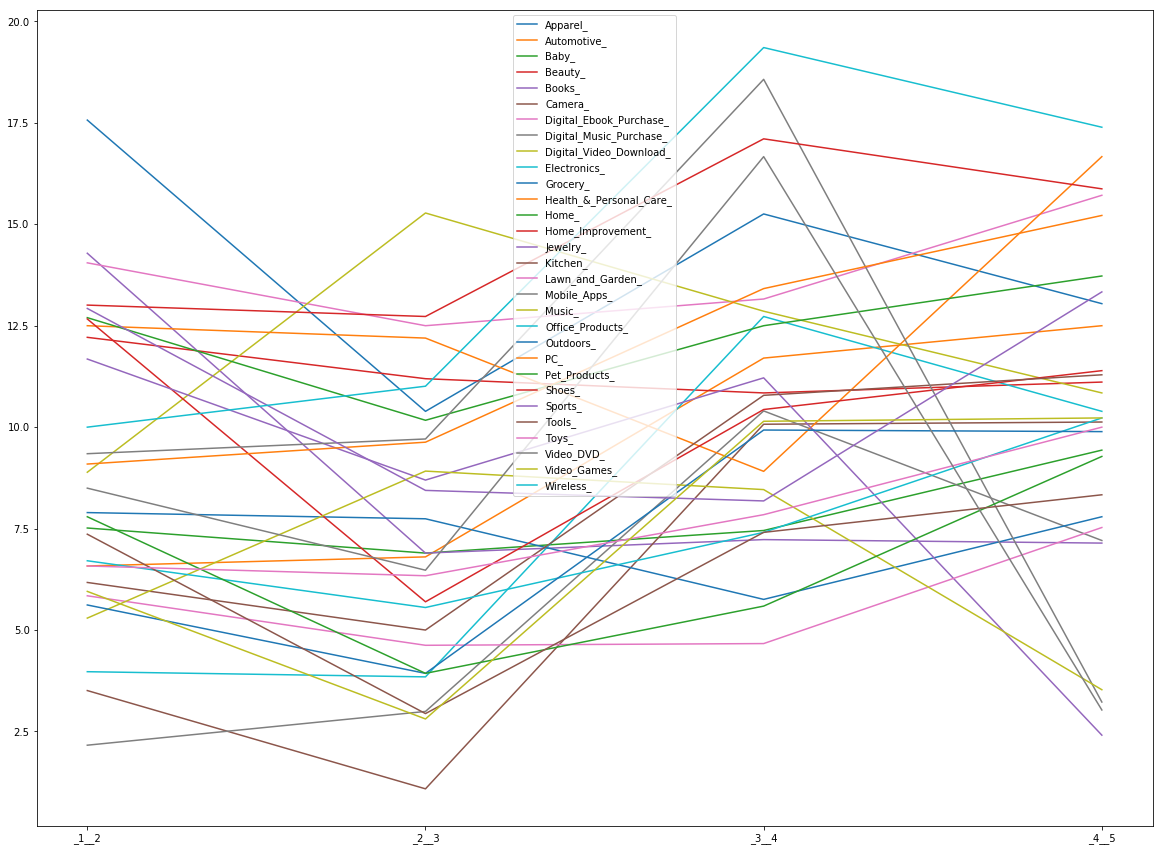

In [23]:
# tfidf_scores_star_rating = prepare_data_for_tfidf(df_product_category_rating, grouping_type = 'star')
df_overlaps_tfidf_star_rating = calc_star_rating_overlap_tfidf(tfidf_scores_star_rating)
plot_star_overlap(df_overlaps_tfidf_star_rating)

**Notes:**

### Build a  multi-class classifier to determine a review category

In this method, we're going to take our learnins from the Tf-IDF experimentation, an train a simple baseline classification model to determine how well the Tf-IDF vectors represent the categories within the dataset.

The First approach will be to build the classifier with only a smaller number of categories (e.g. not segmented by year), and depending ont he results, we will start to increase the dataset labels granularity.


In [ ]:
def train_bayes_classifier_product_category(df):     
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        xs.append(' '.join(res))
        
    ys =  df['product_category']
    print(len(ys), len(xs))
        
    X_train, X_test, y_train, y_test = train_test_split(
        xs, ys, random_state = 0)
    print('Training Data Size: {}'.format(len(X_train)))
    count_vect = CountVectorizer(max_features=10000)
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)    
    
    #Set up a Classifier, and train.
    clf = LinearSVC(verbose =2)
    clf.fit(X_train_tfidf, y_train)

    return clf, count_vect, X_test, y_test
    
model_cat, count_vect_cat, X_test_cat, y_test_cat = train_bayes_classifier_product_category(sampled_data)

1437684 1437684
Training Data Size: 1078263
[LibLinear]

In [36]:
def predict(model, count_vect, X_test, y_test):
    
    X_test_counts = count_vect.transform(X_test)
    y_preds = model.predict(X_test_counts)
    print(y_preds)
    
    print(metrics.classification_report(y_test, y_preds))# target_names=df['product_category'].unique()))
   
predict(model_cat, count_vect_cat, X_test_cat, y_test_cat)

['Video_DVD' 'Video_DVD' 'Music' ... 'Digital_Video_Download' 'Wireless'
 'Digital_Video_Download']
                        precision    recall  f1-score   support

               Apparel       0.55      0.69      0.61     15334
            Automotive       0.54      0.45      0.49      8824
                  Baby       0.40      0.51      0.45      4146
                Beauty       0.60      0.66      0.63     12596
                 Books       0.64      0.79      0.71     48164
                Camera       0.61      0.61      0.61      4333
Digital_Ebook_Purchase       0.69      0.57      0.62     42637
Digital_Music_Purchase       0.77      0.32      0.45      4022
Digital_Video_Download       0.59      0.40      0.47      9788
           Electronics       0.56      0.49      0.53      8007
               Grocery       0.65      0.68      0.66      5875
Health_&_Personal_Care       0.51      0.37      0.43     12910
                  Home       0.53      0.37      0.44     15425
   

**Notes**: From the results of the Tf-IFD vector implementation for modelling, the results generally look pretty accurate for both precision and recall, across all classes. It's important to remember this based on a 1% sample of the total dataset, and that we're filtering lots of the terms

The uses of this model could be to customer or operations focused,

### Model for Product Category and Star Rating

In [28]:
def train_bayes_classifier_product_category_star_rating(df):     
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        xs.append(' '.join(res))
        
    df["label"] = df["product_category"].astype(str) +'_stars_'+  df["star_rating"].astype(str)
    ys =  df['label']
#     print(ys)
    print(len(ys), len(xs))
        
    X_train, X_test, y_train, y_test = train_test_split(
        xs, ys, random_state = 0)
    print('Training Data Size: {}'.format(len(X_train)))
    count_vect = CountVectorizer(max_features=10000)
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)    
    
    #Set up a Classifier, and train.
    clf = LinearSVC(verbose = 1)
    clf.fit(X_train_tfidf, y_train)

    return clf, count_vect, X_test, y_test
    
model_stars, count_vect_stars, X_test_stars, y_test_stars = train_bayes_classifier_product_category_star_rating(sampled_data)

1437684 1437684
Training Data Size: 1078263
[LibLinear]

In [31]:
predict(model_stars, count_vect_stars, X_test_stars, y_test_stars)

['Video_DVD_stars_5' 'Video_DVD_stars_5' 'Music_stars_4' ...
 'Digital_Video_Download_stars_1' 'Wireless_stars_5'
 'Digital_Video_Download_stars_5']
                                precision    recall  f1-score   support

               Apparel_stars_1       0.25      0.34      0.29      1197
               Apparel_stars_2       0.16      0.04      0.06       956
               Apparel_stars_3       0.20      0.07      0.10      1661
               Apparel_stars_4       0.24      0.15      0.18      3002
               Apparel_stars_5       0.37      0.60      0.46      8518
            Automotive_stars_1       0.22      0.12      0.16       766
            Automotive_stars_2       0.09      0.02      0.03       341
            Automotive_stars_3       0.06      0.01      0.02       619
            Automotive_stars_4       0.15      0.03      0.04      1286
            Automotive_stars_5       0.43      0.42      0.42      5812
                  Baby_stars_1       0.07      0.13      0

**Notes**: As expected, when developing a model for multi-class classification problems, as the class space becomes large, the level of accuracy across classes will drop accordingly. This experiment was mainly to determine the seperation of reviews between star ratings, in relation to the product_cateogy, and then, to determine the cross-over in terminology used between star ratings, segmented by product_category

## State-of-the-Art Modelling

In the following section we're going to explore state-of-the-art models to perform product category prediction, in order to determine how much improvement we can obtain by using recent techniques for NLP

### Word Embeddings Using BlazingText (Supervised)
BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence and the corresponding label(s) prefixed by "_ _label_ _".

In [6]:
train_file = 'amazonreviews.train'
test_file = 'amazonreviews.test'

In [57]:
def prep_data_for_supervised_blazing_text(df, train_file_output_name, test_file_output_name):
    
    label_prefix = "__label__"    
    labels = (label_prefix + df['product_category']).tolist()
    #and tokenized words
    tmp = df['review_body_processed']
    xs = []
    for entry in tmp:
        res = str(entry).strip('][').split(', ') 
        res = ' '.join(res)
        xs.append(res)
    
   
    #ensure the lengths
    print('Reviews {}, Labels {}'.format(len(xs), len(labels)))
    
    
    
    #split the data into test and train for supervised mode
    X_train, X_test, y_train, y_test = train_test_split(
        xs, labels, random_state = 0)
    
    
    train_prepped = []
    #train
    for i in range(0, len(X_train)):
        row = str(y_train[i]) + " " + str(X_train[i])
        train_prepped.append([row])
    print('Example Train Processed Data: {}'.format(train_prepped[0]))
    
    test_prepped = []
    #train
    for i in range(0, len(X_test)):
        row = str(y_test[i]) + " " + str(X_test[i])
        test_prepped.append([row])
    print('')
    print('Example Test Processed Data: {}'.format(test_prepped[0]))
    
    with open(train_file_output_name, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', 
                                lineterminator='\n',  
                                escapechar=' ', 
                                quoting=csv.QUOTE_NONE)
        csv_writer.writerows(train_prepped)

    with open(test_file_output_name, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', 
                                lineterminator='\n',  
                                escapechar=' ', 
                                quoting=csv.QUOTE_NONE)        
        csv_writer.writerows(test_prepped)

        
prep_data_for_supervised_blazing_text(sampled_data, train_file , test_file)         
    

Reviews 1437684, Labels 1437684
Example Train Processed Data: ['__label__Pet_Products love product gives extra nutrients dogs need dog loves flavor problem eating food noticed improvement skin coat definitely recommend']

Example Test Processed Data: ['__label__Video_DVD big bus1976 first comedy poke fun 1970s disaster movies airplane1980 right people still quote stuff movie dont call shirley two black guys speak jivebet babe slide piece porter drinks ill run java film also unofficial remake 1958 drama zero hour jim abrahams david zucker jerry zucker worked tv show police squad1982 paramount pictures used resources make airplane ii sequel1982 music score late elmer bernstein good work love theme quite tender used tv commercials airplane packed humor gags ted striker dances disco music plane flies behind clouds jaws theme music plays music score boy girl act like refined adults auto pilot inflatable blow doll called otto 1980 people sick hollywood disaster movies spoof like released rig

In [58]:
def upload_corpus_to_s3(configs, global_vars, train_file , test_file):
    
    
    train_prefix = 'train'
    test_prefix = 'test'
    s3_bucket = global_vars['s3_bucket']
    
    sess = global_vars['sess']
    bucket = global_vars['s3_bucket']
   
    data_file_s3 = '{}/{}/{}'.format(configs['wordvecdata'], train_prefix, train_file)
    s3_bucket.upload_file(train_file, data_file_s3)   

    
    data_file_s3 = '{}/{}/{}'.format(configs['wordvecdata'], test_prefix, test_file)
    s3_bucket.upload_file(test_file, data_file_s3) 
    
    
    s3_train_data = 's3://{}/{}/{}'.format(configs['bucket_name'], configs['wordvecdata'], train_prefix)
    s3_test_data = 's3://{}/{}/{}'.format(configs['bucket_name'], configs['wordvecdata'], test_prefix)
    s3_output_location = 's3://{}/{}/output'.format(configs['bucket_name'], configs['wordvecdata'])
    
    configs['s3_w2v_train_data'] = s3_train_data
    configs['s3_w2v_test_data'] = s3_test_data
    configs['s3_w2v_output_location'] = s3_output_location

    print('S3 Training Data Path {}'.format(s3_train_data))
    print('S3 Test Data Path {}'.format(s3_test_data))

    print('S3 output Data Path {}'.format(s3_output_location))

    return configs

configs = upload_corpus_to_s3(configs, global_vars, train_file , test_file)     

S3 Training Data Path s3://demos-amazon-reviews/wordvec-data/train
S3 Test Data Path s3://demos-amazon-reviews/wordvec-data/test
S3 output Data Path s3://demos-amazon-reviews/wordvec-data/output


In [59]:
def configure_estimator(configs, global_vars):
    
    region_name = configs['aws_region'] 
    sess = global_vars['sess']
    container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
    print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

    bt_model = sagemaker.estimator.Estimator(container,
                                         global_vars['role'], 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c5.18xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=configs['s3_w2v_output_location'],
                                         sagemaker_session=sess)
    
    bt_model.set_hyperparameters(mode="supervised",
                                 epochs=20,
                                 min_count=2,
                                 learning_rate=0.05,
                                 vector_dim=10,
                                 early_stopping=False,
                                 patience=4,
                                 min_epochs=10,
                                 word_ngrams=4)
    
    train_data = sagemaker.session.s3_input(configs['s3_w2v_train_data'], distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

    
    validation_data = sagemaker.session.s3_input(configs['s3_w2v_test_data'], distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
    
    data_channels = {'train': train_data, 'validation': validation_data}
    
   
    global_vars['data_channels'] = data_channels
    global_vars['bt_model'] = bt_model
    
    return global_vars

global_vars = configure_estimator(configs, global_vars)

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [60]:
def fit_model(configs, global_vars):
    
    bt_model = global_vars['bt_model']
    data_channels = global_vars['data_channels']
    bt_model.fit(inputs=data_channels, logs=True)
    
    
fit_model(configs, global_vars)

2020-04-09 04:35:58 Starting - Starting the training job...
2020-04-09 04:36:00 Starting - Launching requested ML instances......
2020-04-09 04:37:06 Starting - Preparing the instances for training...
2020-04-09 04:37:46 Downloading - Downloading input data...
2020-04-09 04:38:21 Training - Training image download completed. Training in progress...Arguments: train
[04/09/2020 04:38:22 WARNING 140625143301952] Loggers have already been setup.
[04/09/2020 04:38:22 WARNING 140625143301952] Loggers have already been setup.
[04/09/2020 04:38:22 INFO 140625143301952] nvidia-smi took: 0.0252759456635 secs to identify 0 gpus
[04/09/2020 04:38:22 INFO 140625143301952] Running single machine CPU BlazingText training using supervised mode.
[04/09/2020 04:38:22 INFO 140625143301952] Processing /opt/ml/input/data/train/amazonreviews.train . File size: 274 MB
[04/09/2020 04:38:22 INFO 140625143301952] Processing /opt/ml/input/data/validation/amazonreviews.test . File size: 91 MB
Read 10M words
Read 

In [61]:
def host_model(global_vars):
    
    bt_model = global_vars['bt_model']
    text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')
    global_vars['w2v_classifier'] = text_classifier
    
    return global_vars

global_vars = host_model(global_vars)

-------------!

In [120]:
def evaluate_test_data_against_model(global_vars, test_file):
    
    train_data = []
    instances = []
    with open(test_file, 'r', newline= '\n') as csvinputfile:
        data = csv.reader(csvinputfile)
        for row in data:
#             print(row)
            label = row[0].split(' ')[0]
            text = row[0].partition(' ')[2].replace('  ',' ').strip()
            tmp = {'label':label, "text":text}
            train_data.append(tmp)
#             print(tmp)
#             break
            #same order as the csv rows
            instances.append(text)
            
            

    print('Total Instances {}. Total Train Data {}'.format(len(instances), len(train_data)))

#     print(instances[0], train_data[0]['label'])
    
    # we need to do some batch inferencing due to the size of the data:
    
    #each batch is 1000 sentences
    batch_size = 10000
    batches = len(instances) // batch_size
    
    print('Batches {}'.format(batches))
    
    predictions_batches = []
    
    for i in range(0, batches+1):
        lower = batch_size * i
        upper = batch_size * (i+1)
        if i == batches:
            upper = len(instances)
        print('Batch {} : {}'.format(lower,upper))
            
        instances_batch = instances[lower:upper]
        
        payload = {"instances":instances_batch,
                  "configuration": {"k": 1}}

        text_classifier =  global_vars['w2v_classifier']


        response = text_classifier.predict(json.dumps(payload))

        predictions = json.loads(response)
        predictions_batches.append(predictions)
        
#     print(json.dumps(predictions, indent=2))
    print('Total Predictions {}'.format(len(predictions)))
        
    return predictions_batches, train_data
            
            
                
predictions_batches, train_data = evaluate_test_data_against_model(global_vars, test_file)

Total Instances 359421. Total Train Data 359421
Batches 35
Batch 0 : 10000
Batch 10000 : 20000
Batch 20000 : 30000
Batch 30000 : 40000
Batch 40000 : 50000
Batch 50000 : 60000
Batch 60000 : 70000
Batch 70000 : 80000
Batch 80000 : 90000
Batch 90000 : 100000
Batch 100000 : 110000
Batch 110000 : 120000
Batch 120000 : 130000
Batch 130000 : 140000
Batch 140000 : 150000
Batch 150000 : 160000
Batch 160000 : 170000
Batch 170000 : 180000
Batch 180000 : 190000
Batch 190000 : 200000
Batch 200000 : 210000
Batch 210000 : 220000
Batch 220000 : 230000
Batch 230000 : 240000
Batch 240000 : 250000
Batch 250000 : 260000
Batch 260000 : 270000
Batch 270000 : 280000
Batch 280000 : 290000
Batch 290000 : 300000
Batch 300000 : 310000
Batch 310000 : 320000
Batch 320000 : 330000
Batch 330000 : 340000
Batch 340000 : 350000
Batch 350000 : 359421
Total Predictions 9421


In [128]:
def evaluate_model_predictions(predictions_batches, train_data):
    
    preds = []
    for batch in predictions_batches:
        for pred in batch:
            lab = pred['label'][0]
            prob = pred['prob'][0]
            tmp = {'pred_label':lab, 'pred_prob':prob}
            preds.append(tmp)
            
    print('Total Preds {}'.format(len(preds)))
    
    for i in range(0,len(train_data)):
        data = train_data[i]
        true_label = data['label']
        preds[i]['true_label'] = true_label
        
    print('Example Data: \n\t {}'.format(preds[1]))
    
    y_true = []
    y_pred = []
    for pred in preds:
        y_true.append(pred['true_label'].replace('__label__',''))
        y_pred.append(pred['pred_label'].replace('__label__',''))
        
    print(classification_report(y_true, y_pred))

        
evaluate_model_predictions(predictions_batches, train_data)

Total Preds 359421
Example Data: 
	 {'pred_label': '__label__Digital_Video_Download', 'pred_prob': 0.5681320428848267, 'true_label': '__label__Digital_Video_Download'}
                        precision    recall  f1-score   support

               Apparel       0.56      0.66      0.60     15334
            Automotive       0.49      0.45      0.47      8824
                  Baby       0.53      0.42      0.47      4146
                Beauty       0.58      0.62      0.60     12596
                 Books       0.65      0.73      0.69     48164
                Camera       0.68      0.52      0.59      4333
Digital_Ebook_Purchase       0.69      0.66      0.68     42637
Digital_Music_Purchase       0.64      0.36      0.46      4022
Digital_Video_Download       0.57      0.53      0.55      9788
           Electronics       0.49      0.47      0.48      8007
               Grocery       0.69      0.63      0.66      5875
Health_&_Personal_Care       0.44      0.45      0.44     12910

**Notes**: Using the Word2Vec word Embedding approach, we're seeing similar results to the TF-IDF/SVC implementation for predicting product category. However, the computational time required to compute the SVC was nearly 100 times slower than the Word2Vec approach, and this is only for a sample dataset of 1% of the total data.

# YET TO BE WORKED ON SAGEMAKER BERT

## Modelling

Here we're going to start to explore different modelling approaches to building our insights and predictive capability for this dataset.

There's a number of model's we're going to first try to develop a word embedding model which will help us develop the underlying structure of our reviews/words which can then be used as latent representations for our sentiment scores 

### Data Prep

Before we can use our data, we need to convert it from Parquet to RecordIO

In [ ]:
%%time

def read_parquet_file(filename):
    pf = ParquetFile(filename)
    return pf.to_pandas()

def convert_parquet_to_recordio(configs, manifest):
    dfs = []
     ##Create Augmented JSON Record file
    aug_train = []
    fs = s3fs.S3FileSystem()
    
    cnt = 0
    maxi = 1000000
    known_dates = {}
    tot_rows = 0
    for x in manifest:
        if cnt < maxi:
            date = x['date']
            if date not in known_dates:
                known_dates[date] = True
                absolute_path = 's3://{}/{}'.format(configs['bucket_name'], x['path_with_prefix'])
                folders = x['path_with_prefix'].split('/')
                path = ''
                for folder in folders:
                    if 'part' not in folder:
                        path = path + '/' + folder
                absolute_path = 's3://{}{}'.format(configs['bucket_name'], path)
                try:
                    dataset = pq.ParquetDataset(absolute_path,filesystem=fs)
                    table = dataset.read()
#                     df = table.to_pandas()
                    tot_rows += df.shape[0]
                    print('date {}. rows {}'.format(x['date'],df.shape[0]))
#                     dfs.append(df)
                    cnt += 1

                except:
                    print('could not load files in folder {}'.format(x['date']))
                
    print('Total Rows {}'.format(tot_rows))
    
    
#     train_file_s3 = 'train_lst/train_manifest.json'
#     s3_bucket.upload_file('./train_manifest.json', train_file_s3)

convert_parquet_to_recordio(configs, sampled_manifest)


In [ ]:
def upload_manifest(configs, manifest):
    
     ##Create Augmented JSON Record file
    aug_train = []
    
    for x in manifest:
        absolute_path = 's3://{}/{}'.format(configs['bucket_name'], x['path_with_prefix'])
        dic = {'source-ref':absolute_path}
        aug_train.append(dic)
        print(aug_train)
        break
    with open('train_manifest.json', 'w') as fout:
        for x in aug_train:
            fout.write(json.dumps(x)+'\n')
            #json.dump(aug_train, fout, indent=4)
    
        
    
#     train_file_s3 = 'train_lst/train_manifest.json'
#     s3_bucket.upload_file('./train_manifest.json', train_file_s3)

upload_manifest(configs, sampled_manifest)